In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from matplotlib import image
from matplotlib import pyplot
import time
from torchvision.models.mobilenet import mobilenet_v2

In [ ]:
def image_preprocess(path, train_split, val_split, batch_size, inp_size):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  train_transform=transforms.Compose([transforms.Resize(inp_size), transforms.RandomVerticalFlip(), 
                                transforms.CenterCrop(inp_size[0]), transforms.ToTensor(), normalize])
  val_transform = transforms.Compose([transforms.Resize(inp_size), transforms.ToTensor(), normalize])
  train_data = datasets.ImageFolder(root=path+"/train", transform=train_transform)
  val_data = datasets.ImageFolder(root=path+"/val",transform=val_transform)
  test_data = datasets.ImageFolder(root=path+"/test",transform=val_transform)
  print(val_data)
  # test_split = round((1-train_split-val_split), 2)
  # print(data_length, int(train_split*data_length),int(val_split*data_length), int(test_split*data_length))

  data_length = len(val_data)
  # The no. of images in each split of train, val and test
  train_size = int(0.3*data_length)
  val_size = int(0.6*data_length)
  test_size = data_length - val_size - train_size
  val_data, _, _ = td.random_split(val_data, [train_size, val_size, 
                                                    test_size])
  
  print(len(val_data))
  # Create the data loaders
  train_loader = td.DataLoader(train_data,  batch_size=batch_size, 
                               shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  val_loader = td.DataLoader(val_data,  batch_size=batch_size, 
                             shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  test_loader = td.DataLoader(test_data, batch_size=batch_size, 
                              shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  
  return train_loader, val_loader, test_loader

In [ ]:
# Initialize the data loaders through the image_preprocess function
path = "/content/drive/MyDrive/AI Final Project/fourClass"
train_loader, val_loader, test_loader = image_preprocess(path, 0.7, 0.1, 32, (224, 224))

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /content/drive/MyDrive/AI Final Project/fourClass/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
600


In [ ]:
# Loader data plotted for visualizaion
def plot_data_loader(loader, grid):
  fig, axes = plt.subplots(nrows=grid[0], ncols=grid[1], figsize=(6,6))
  dataiter = iter(loader)
  for i in range(grid[0]):
    for j in range(grid[1]):
      images, _ = next(dataiter)
      axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

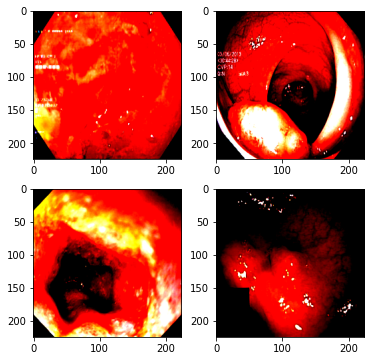

In [ ]:
plot_data_loader(train_loader, [2,2])

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, lossFunc, epochs=20):
    start = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))

    best_model_weights = model.state_dict()
    best_accuracy = 0

    train_accuracy_list = []
    val_accuracy_list = []

    for epoch in range(1,epochs+1):
      for i, train_batch in enumerate(train_loader):
        images, labels, model = train_batch[0].to(device), train_batch[1].to(device), model.to(device)

        outputs = model(images)
        loss = lossFunc(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()

        for j, val_batch in enumerate(val_loader):
          images_, labels_ = val_batch[0].to(device), val_batch[1].to(device)
          outputs_ = model(images_)
          loss_ = lossFunc(outputs_, labels_)
          total_ = labels_.size(0)
          _,predicted_ = torch.max(outputs_.data, 1)
          correct_ = (predicted_ == labels_).sum().item()

        train_loss = loss.item()
        train_accuracy = (correct / total) * 100
        train_accuracy_list.append(train_accuracy)
        val_loss = loss_.item()
        val_accuracy = (correct_ / total_) * 100
        val_accuracy_list.append(val_accuracy)

        if val_accuracy > best_accuracy:
          best_accuracy = val_accuracy
          best_model_weights = model.state_dict()

        print("Epoch [{}/{}], Train_Loss: {:.4f}, Train_Accuracy: {:.2f}%  Val_Loss: {:.4f}, Val_Accuracy: {:.2f}%"
                .format(epoch, epochs, train_loss, train_accuracy, val_loss, val_accuracy))
    end = time.time()    
    print("######## Training Finished in {} seconds ###########".format(end-start))
    model.load_state_dict(best_model_weights)
    return model, train_accuracy_list, val_accuracy_list, best_accuracy

In [ ]:
# Model definition and initialization
model = resnet50()
num_ftrs = model.fc.in_features
path =  "/content/drive/MyDrive/AI Final Project/fourClass"
classes = os.listdir(path+"/train")
model.fc = torch.nn.Linear(num_ftrs, len(classes))
optimizer = torch.optim.Adam(params=model.parameters())
loss = torch.nn.CrossEntropyLoss()

In [ ]:
import torchvision
model = torchvision.models.vgg16(pretrained=False)
num_features =model.classifier[6].in_features
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.001)
loss = torch.nn.CrossEntropyLoss()
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 4)]) # Add our layer with 4 outputs
model.classifier = nn.Sequential(*features)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
best_model, training_accuracy_list, val_accuracy_list, best_accuracy = train_model(model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, lossFunc=loss, epochs=20)

Device: cuda:0
Epoch [1/20], Train_Loss: 1.3922, Train_Accuracy: 28.12%  Val_Loss: 1.3764, Val_Accuracy: 29.17%
Epoch [1/20], Train_Loss: 1.3981, Train_Accuracy: 18.75%  Val_Loss: 1.3975, Val_Accuracy: 20.83%
Epoch [1/20], Train_Loss: 1.3877, Train_Accuracy: 21.88%  Val_Loss: 1.3798, Val_Accuracy: 29.17%
Epoch [1/20], Train_Loss: 1.3863, Train_Accuracy: 21.88%  Val_Loss: 1.4068, Val_Accuracy: 16.67%
Epoch [1/20], Train_Loss: 1.3832, Train_Accuracy: 18.75%  Val_Loss: 1.3985, Val_Accuracy: 12.50%
Epoch [1/20], Train_Loss: 1.3991, Train_Accuracy: 15.62%  Val_Loss: 1.3854, Val_Accuracy: 16.67%
Epoch [1/20], Train_Loss: 1.3874, Train_Accuracy: 12.50%  Val_Loss: 1.3803, Val_Accuracy: 29.17%
Epoch [1/20], Train_Loss: 1.3661, Train_Accuracy: 31.25%  Val_Loss: 1.3960, Val_Accuracy: 29.17%
Epoch [1/20], Train_Loss: 1.3896, Train_Accuracy: 25.00%  Val_Loss: 1.4172, Val_Accuracy: 16.67%
Epoch [1/20], Train_Loss: 1.3882, Train_Accuracy: 25.00%  Val_Loss: 1.3849, Val_Accuracy: 25.00%
Epoch [1/20], T

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [6/20], Train_Loss: 0.8548, Train_Accuracy: 59.38%  Val_Loss: 0.9018, Val_Accuracy: 58.33%
Epoch [6/20], Train_Loss: 0.7821, Train_Accuracy: 68.75%  Val_Loss: 1.2675, Val_Accuracy: 58.33%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [6/20], Train_Loss: 0.7794, Train_Accuracy: 71.88%  Val_Loss: 1.0151, Val_Accuracy: 58.33%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [6/20], Train_Loss: 0.8851, Train_Accuracy: 59.38%  Val_Loss: 0.7375, Val_Accuracy: 79.17%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

    Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

assert self._parent_pid == os.getpid(), 'can only test a child process'AssertionError    : self._shutdown_workers()can only test a child process

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():Exception ignored in: <

Epoch [6/20], Train_Loss: 0.6664, Train_Accuracy: 78.12%  Val_Loss: 0.9313, Val_Accuracy: 58.33%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

    Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    AssertionErrorself._shutdown_workers(): 
can only test a child process  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers

    if w.is_alive():
Exception ignored in: 

Epoch [6/20], Train_Loss: 0.6674, Train_Accuracy: 75.00%  Val_Loss: 1.0233, Val_Accuracy: 45.83%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>: 
can only test a child processTraceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/da

Epoch [6/20], Train_Loss: 0.6551, Train_Accuracy: 81.25%  Val_Loss: 0.9041, Val_Accuracy: 62.50%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
AssertionError  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
: can only test a child process    
self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
Exception ignored in:     <function _MultiP

Epoch [6/20], Train_Loss: 0.9193, Train_Accuracy: 65.62%  Val_Loss: 0.8879, Val_Accuracy: 58.33%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>    
if w.is_alive():Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
AssertionError:     can only test a child processif w.is_alive():

  File "/usr/lib/pytho

Epoch [6/20], Train_Loss: 0.7127, Train_Accuracy: 81.25%  Val_Loss: 0.9563, Val_Accuracy: 45.83%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):
      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'
    AssertionErrorself._shutdown_workers(): 
can only test a child process  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers

    if w.is_alive():Exception ignored in: 


Epoch [6/20], Train_Loss: 0.9010, Train_Accuracy: 59.38%  Val_Loss: 0.9267, Val_Accuracy: 62.50%
Epoch [6/20], Train_Loss: 0.7057, Train_Accuracy: 65.62%  Val_Loss: 0.7365, Val_Accuracy: 75.00%
Epoch [6/20], Train_Loss: 0.6493, Train_Accuracy: 75.00%  Val_Loss: 1.1036, Val_Accuracy: 54.17%
Epoch [6/20], Train_Loss: 0.8363, Train_Accuracy: 68.75%  Val_Loss: 0.7897, Val_Accuracy: 70.83%
Epoch [6/20], Train_Loss: 0.7854, Train_Accuracy: 59.38%  Val_Loss: 1.0353, Val_Accuracy: 50.00%
Epoch [6/20], Train_Loss: 0.6978, Train_Accuracy: 71.88%  Val_Loss: 0.8887, Val_Accuracy: 54.17%
Epoch [6/20], Train_Loss: 0.6695, Train_Accuracy: 75.00%  Val_Loss: 0.9359, Val_Accuracy: 62.50%
Epoch [6/20], Train_Loss: 0.7749, Train_Accuracy: 81.25%  Val_Loss: 1.1331, Val_Accuracy: 54.17%
Epoch [6/20], Train_Loss: 0.7492, Train_Accuracy: 65.62%  Val_Loss: 0.8841, Val_Accuracy: 66.67%
Epoch [6/20], Train_Loss: 0.7450, Train_Accuracy: 65.62%  Val_Loss: 1.2834, Val_Accuracy: 45.83%
Epoch [6/20], Train_Loss: 0.64

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [7/20], Train_Loss: 0.7408, Train_Accuracy: 71.88%  Val_Loss: 0.9046, Val_Accuracy: 62.50%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.8/dist-packages/torch/ut

Epoch [7/20], Train_Loss: 0.7020, Train_Accuracy: 65.62%  Val_Loss: 0.7102, Val_Accuracy: 66.67%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [7/20], Train_Loss: 0.7686, Train_Accuracy: 62.50%  Val_Loss: 0.8769, Val_Accuracy: 70.83%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [7/20], Train_Loss: 0.6186, Train_Accuracy: 75.00%  Val_Loss: 0.8881, Val_Accuracy: 62.50%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionErrorTraceback (most recent call last):
:   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
can only test a child process
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
<function _MultiProce

Epoch [7/20], Train_Loss: 0.6781, Train_Accuracy: 71.88%  Val_Loss: 0.7040, Val_Accuracy: 66.67%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>

AssertionErrorTraceback (most recent call last):
:   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
can only test a child process
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
<function _MultiProce

Epoch [7/20], Train_Loss: 0.6160, Train_Accuracy: 68.75%  Val_Loss: 0.7328, Val_Accuracy: 62.50%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
AssertionError  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
: can only test a child process    
self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
Exception ignored in:     <function _MultiP

Epoch [7/20], Train_Loss: 0.5973, Train_Accuracy: 75.00%  Val_Loss: 0.8768, Val_Accuracy: 54.17%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Exception ignored in: can only test a child process
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3

Epoch [7/20], Train_Loss: 0.4861, Train_Accuracy: 84.38%  Val_Loss: 0.7408, Val_Accuracy: 62.50%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>: 
can only test a child processTraceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/d

Epoch [7/20], Train_Loss: 0.6942, Train_Accuracy: 59.38%  Val_Loss: 0.6645, Val_Accuracy: 75.00%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/

Epoch [7/20], Train_Loss: 0.6057, Train_Accuracy: 75.00%  Val_Loss: 0.5598, Val_Accuracy: 75.00%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>can only test a child process

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3

Epoch [7/20], Train_Loss: 0.6469, Train_Accuracy: 78.12%  Val_Loss: 0.8814, Val_Accuracy: 66.67%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>

AssertionErrorTraceback (most recent call last):
: can only test a child process  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
<function _MultiProce

Epoch [7/20], Train_Loss: 0.6780, Train_Accuracy: 78.12%  Val_Loss: 0.8399, Val_Accuracy: 62.50%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: AssertionError: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>can only test a child process

Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.

Epoch [7/20], Train_Loss: 0.5279, Train_Accuracy: 68.75%  Val_Loss: 1.4205, Val_Accuracy: 50.00%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
AssertionError:     can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    Exception ignored in: if w.is_alive():<

Epoch [7/20], Train_Loss: 0.5829, Train_Accuracy: 68.75%  Val_Loss: 1.3311, Val_Accuracy: 54.17%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>    
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorTraceback (most recent call last):
:   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
Exception ignored in:     if w.is_alive():<

Epoch [7/20], Train_Loss: 0.5773, Train_Accuracy: 81.25%  Val_Loss: 0.8210, Val_Accuracy: 66.67%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>Traceback (most recent call last):

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.8/dist-packages/torch/ut

Epoch [7/20], Train_Loss: 0.7082, Train_Accuracy: 68.75%  Val_Loss: 0.9864, Val_Accuracy: 62.50%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f5fb585ad30>
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.

Epoch [7/20], Train_Loss: 0.5302, Train_Accuracy: 78.12%  Val_Loss: 0.9061, Val_Accuracy: 66.67%
Epoch [7/20], Train_Loss: 0.7996, Train_Accuracy: 59.38%  Val_Loss: 0.7268, Val_Accuracy: 62.50%
Epoch [7/20], Train_Loss: 0.6276, Train_Accuracy: 62.50%  Val_Loss: 0.7260, Val_Accuracy: 62.50%
Epoch [7/20], Train_Loss: 0.6354, Train_Accuracy: 68.75%  Val_Loss: 1.2292, Val_Accuracy: 50.00%
Epoch [7/20], Train_Loss: 0.5187, Train_Accuracy: 75.00%  Val_Loss: 0.6728, Val_Accuracy: 70.83%
Epoch [7/20], Train_Loss: 0.6279, Train_Accuracy: 71.88%  Val_Loss: 1.0541, Val_Accuracy: 54.17%
Epoch [7/20], Train_Loss: 0.7119, Train_Accuracy: 65.62%  Val_Loss: 0.7366, Val_Accuracy: 66.67%
Epoch [7/20], Train_Loss: 0.4433, Train_Accuracy: 87.50%  Val_Loss: 0.5713, Val_Accuracy: 66.67%
Epoch [7/20], Train_Loss: 0.5455, Train_Accuracy: 81.25%  Val_Loss: 1.1789, Val_Accuracy: 54.17%
Epoch [7/20], Train_Loss: 0.5406, Train_Accuracy: 75.00%  Val_Loss: 1.0807, Val_Accuracy: 45.83%
Epoch [7/20], Train_Loss: 0.44

In [ ]:
vgg16_fourclass = {'model': best_model,
               'training_accuracy_list': training_accuracy_list,
               'val_accuracy_list': val_accuracy_list,
              'state_dict': best_model.state_dict()}
torch.save(vgg16_fourclass, '/content/drive/MyDrive/AI Final Project/vgg16_fourclass.pth')

In [ ]:
len(training_accuracy_list)

2000

In [ ]:
?resNet_fourclass = {'model': "Res_net_fourclass",
               'training_accuracy_list': training_accuracy_list,
               'val_accuracy_list': val_accuracy_list,
              'state_dict': best_model.state_dict()}
torch.save(resNet_fourclass, 'resNet_fourclass.pth')

NameError: ignored

In [ ]:
len(train_loader)

100

In [ ]:
def train_val_comparison(train_accuracy_list, val_accuracy_list, loader_length):
    x = np.linspace(0, 20, num=100*20)
    plt.figure(figsize=(20,5))
    plt.plot(x, train_accuracy_list, label="Train")
    plt.plot(x, val_accuracy_list, label="Validation")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation")
    plt.legend()

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, lossFunc, epochs=10):
    start = time.time()

    if torch.cuda.is_available():
      device = torch.device("cuda:0")
      print("running on the GPU")
    else:
      device = torch.device("cpu")
      print("running on the CPU")

   #best_model_weights = model.state_dict()
    #best_accuracy = 0 

    train_accuracy_list = []
    val_accuracy_list = []

    for epoch in range(1,epochs+1):
      for i, train_batch in enumerate(train_loader):
        images, labels, model = train_batch[0].to(device), train_batch[1].to(device), model.to(device)

        outputs = model(images)
        loss = lossFunc(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()

        for j, val_batch in enumerate(val_loader):
          images_, labels_ = val_batch[0].to(device), val_batch[1].to(device)
          outputs_ = model(images_)
          loss_ = lossFunc(outputs_, labels_)
          total_ = labels_.size(0)
          _,predicted_ = torch.max(outputs_.data, 1)
          correct_ = (predicted_ == labels_).sum().item()

        train_loss = loss.item()
        train_accuracy = (correct / total) * 100
        train_accuracy_list.append(train_accuracy)
        val_loss = loss_.item()
        val_accuracy = (correct_ / total_) * 100
        val_accuracy_list.append(val_accuracy)    

        print("Epoch [{}/{}], Train_Loss: {:.4f}, Train_Accuracy: {:.2f}%  Val_Loss: {:.4f}, Val_Accuracy: {:.2f}%"
                .format(epoch, epochs, train_loss, train_accuracy, val_loss, val_accuracy))
    end = time.time()    
    print("######## Training Finished in {} seconds ###########".format(end-start))
    return model, train_accuracy_list, val_accuracy_list